# A08 Q2: RNN and BPTT

In [6]:
import numpy as np
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import copy
from tqdm import tqdm
from termcolor import colored  # for printing coloured text
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [7]:
import re
class Origin(torch.utils.data.Dataset):
    '''
     ds = Origin(seq_length=10, start=0, stop=-1)
     
     Creates a PyTorch Dataset object, holding a simplified version
     of the text from Charles Darwin's "On the Origin of Species".
     
     The class contains utility functions to convert between the
     string-based form of a sequence, and its vector encoding, in which
     each character is represented by a one-hot 28-vector corresponding
     to the 28 characters in the string
       ' .abcdefghijklmnopqrstuvwxyz'  (the first character is a space)
     
     The target sequences are the same as the inputs, but advanced by
     one character.
     
     Inputs:
      seq_length  the number of characters in each sequence
      start       the index of the character to start taking sequences from
      stop        the index of the character to stop taking sequences from
      
     Usage:
      ds = Origin(seq_length=5, start=7, stop=100)
      x,t = ds.__getitem__(0)
      print(ds.read_seq(x))   # Produces 'origi'
      print(ds.read_seq(t))   # Produces 'rigin'
    '''
    def __init__(self, seq_length=10, start=0, stop=-1):
        self.seq_length = seq_length

        orig_text = open('origin_of_species.txt').read().lower()
        chars = sorted(list(set(orig_text)))
        chars.insert(0, "\0") #Add newline character
        vocab_size = len(chars)

        char_indices = dict((c, i) for i, c in enumerate(chars))
        indices_char = dict((i, c) for i, c in enumerate(chars))
        idx = [char_indices[c] for c in orig_text]

        # Let's simplify it by keeping only letters, spaces, and periods.
        filt_idx = []
        for i in idx:
            if i<=24 and i!=10:
                filt_idx.append(2)
            elif i>24 or i==10:
                filt_idx.append(i)
        blah = ''.join([indices_char[f] for f in filt_idx])
        self.text = re.sub(' +', ' ', blah)  # collapse multiple spaces using regular expressions
        self.text = self.text[start:stop]
        #chars = sorted(list(set(self.text)))
        chars = sorted(list(set(' .abcdefghijklmnopqrstuvwxyz')))
        self.vocab_size = len(chars)
        print('Character set: '+''.join(chars)+' (first char is a space)')

        self.char_indices = dict((c, i) for i, c in enumerate(chars))
        self.indices_char = dict((i, c) for i, c in enumerate(chars))
        self.idx = [self.char_indices[c] for c in self.text]

        print('There are '+str(self.vocab_size)+' characters in our character set')

    def __len__(self):
        return len(self.text) - 1 - self.seq_length
    
    def __getitem__(self, k):
        x = self.idx[k:k+self.seq_length]
        t = self.idx[k+1:k+1+self.seq_length]
        return self.seq_i2v(x), torch.tensor(t, dtype=torch.long)
      
    def seq_i2v(self, seq):
        x = torch.zeros((len(seq), self.vocab_size))
        for k,i in enumerate(seq):
            x[k,i] = 1.
        return x
    
    def read_seq(self, x):
        idx = [torch.argmax(v).item() for v in x]        
        return ''.join(self.indices_char[i] for i in idx)
    
    def encode_seq(self, c):
        idx = [self.char_indices[cc] for cc in c]
        return self.seq_i2v(idx)

In [8]:
# Create the dataset
oos = Origin(start=11000, stop=21000, seq_length=10)

Character set:  .abcdefghijklmnopqrstuvwxyz (first char is a space)
There are 28 characters in our character set


In [9]:
# How many sequences?
len(oos)

9989

In [10]:
# You can access the original (simplified) text.
oos.text[820:900]

'en yield new varieties our oldest domesticated animals are still capable of rapi'

In [11]:
x, t = oos.__getitem__(0)

In [12]:
print('Here is how you can view one of the samples:')
print(f'Sample input: "{oos.read_seq(x)}"')

Here is how you can view one of the samples:
Sample input: "treatment "


In [13]:
# Create a PyTorch DataLoader
dl = torch.utils.data.DataLoader(oos, batch_size=128, shuffle=True)

# `GRU` Class

In [14]:
class GRU(nn.Module):
    '''
     net = GRU(dims)
     Input:
       dims is [I, H], where the input/output layers have I neurons, and the
            hidden layer has H neurons.
    '''
    def __init__(self, dims):
        super().__init__()
        self.losses = []
        
        #===== YOUR CODE HERE =====
         
        self.input_dim, self.hidden_dim = dims
        # Input gate weights
        self.wi = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.ui = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        
        # Reset gate weights
        self.ur = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.wr = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        
        # Hidden state weights
        self.uh = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.wh = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        
        # Output layer weights
        self.v = nn.Linear(self.hidden_dim, self.input_dim, bias=True)
        
        
    def step(self, x, h):
        '''
         hnext = net.step(x, h)
         
         Takes a time step, with input x and current hidden state h.
         Returns the new h.
         
         Inputs:
          x      a DxI tensor holding a batch of inputs, where
                    D is the batch size, and
                    I is the dimension of the inputs
          h      a DxH tensor holding a batch of hidden states, where
                    H is the number of hidden nodes
                
         Output:
          hnext  a DxH tensor holding the hidden states for the next
                    timestep
        '''
        #===== YOUR CODE HERE =====
        z = torch.sigmoid(self.ui(x) + self.wi(h))
        r = torch.sigmoid(self.ur(x) + self.wr(h))
        hc = torch.tanh(self.uh(x) + self.wh(r * h))
        hnext = z * hc + (1 - z) * h
        return hnext  
    
    
    def output(self, h):
        '''
         y = net.output(h)
         
         Given the hidden state, returns the *log* of the output.
         ie. for categorical cross-entropy, it should return LogSoftmax.
         
         Input:
          h  a DxH tensor holding a batch of hidden states, where
                D is the batch size, and
                H is the dimension of the hidden state (number of hidden nodes)
                
         Output:
          y  a DxI tensor holding a batch of outputs, where
                I is the dimension of the output
        '''
        #===== YOUR CODE HERE =====
        y = nn.functional.log_softmax(self.v(h), dim=-1)
        return y
    
    
    def forward(self, x):
        '''
         y = net.forward(x)
         
         Takes a batch of squences, and returns the batch of output
         sequences.
         
         Inputs:
          x   a DxTxI tensor, where
                 D is the batch size (number of sequences in the batch)
                 T is the sequence length, and
                 I is the dimension of the input to the network
                 
         Output:
          y   a DxTxI tensor, as above
        '''
        x = x.to(device)  # in case you're using a GPU
        # We have to reorder the batch from (D, T, I) to (T, D, I) so that
        # we can run the batch through the network, one timestep at a time.
        seq_of_batches = torch.einsum('ijk->jik', x)

        output_seq = []
        T, samples, input_dim = seq_of_batches.shape
        h = torch.zeros((samples, self.hidden_dim)).to(device)
        for xt in seq_of_batches:
            h = self.step(xt, h)
            output_seq.append(self.output(h))
        y = torch.stack(output_seq, dim=0).to(device)  # (T, batch_size, output_dim)
        return torch.einsum('jik->ijk', y)  # (batch_size, T, output_dim)

    
    def bptt(self, dl, epochs=10, loss_fcn=nn.NLLLoss(), lr=0.001):
        '''
         net.bptt(dl, epochs=10, loss_fcn=nn.NLLLoss(), lr=0.001)
         
         Trains the recurrent network using Backprop Through Time.
         
         Inputs:
          dl        PyTorch DataLoader object
                    Each batch shoud be shaped DxTxI where
                      D is the number of sequences (samples) in the batch,
                      T is the length of each sequence, and
                      I is dim of each input to the network
          epochs    number of epochs to train for
          loss_fcn  PyTorch loss function
          lr        learning rate
        '''
        optim = torch.optim.Adam(self.parameters(), lr=lr)  # optimizer
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            for x,t in (dl):
                y = self(x)   # process the batch of sequences
                
                # Go through output sequences, and compute loss
                loss = torch.tensor(0., device=device, requires_grad=True)
                for ys,ts in zip(y,t.to(device)):
                    loss = loss + loss_fcn(ys, ts)
                    
                # And this stuff is familiar by now
                optim.zero_grad()
                loss.backward()
                optim.step()
                total_loss += loss.detach().cpu().item()
                
            self.losses.append(total_loss/len(dl))
        plt.plot(self.losses)
        
        
    def predict(self, x, n=10):
        '''
         y = net.predict(x, n=10)
         
         Run the network on sequence x, and then continue to predict
         the next n outputs.
         
         Inputs:
          x  a TxI tensor for a single input sequence
          n  how many output timesteps to predict
          
         Output:
          y  an (n)xI tensor, holding the sequence of n outputs
                predicted after the input sequence
        '''
        assert len(x.shape)==2
        with torch.no_grad():
            h = torch.zeros((1, self.hidden_dim)).to(device)
            for xx in x:  # step through the given sequence
                h = self.step(xx, h)
            y = self.output(h)
            pred = [y]   # for storing the output sequence
            
            # Now we take n more steps, and add the network's output
            for t in range(n-1):
                # Make a one-hot input out of the last output
                c = torch.argmax(y)
                x = torch.zeros_like(y)
                x[0,c] = 1.
                # Take a timestep
                h = self.step(x, h)
                y = self.output(h) # output from prev step becomes input to next step
                pred.append(y)
                
        return torch.stack(pred, dim=0)

# Create and train the GRU

In [15]:
net = GRU([oos.vocab_size, 400])

100%|██████████| 20/20 [03:10<00:00,  9.50s/it]


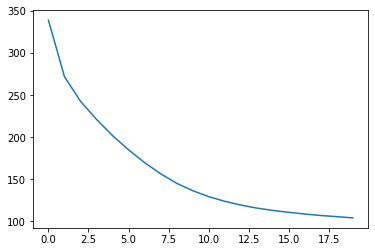

In [16]:
net.bptt(dl, epochs=20, loss_fcn=nn.NLLLoss(reduction='mean'), lr=0.001)

In [18]:
# Use these lines to save and load your trained network.
torch.save(net.cpu(), 'mygru.pt')
net = torch.load('mygru.pt').to(device)

# Evaluate the network

In [19]:
# Choose a random seed sequence
k = np.random.randint(0, high=len(oos))
rs = oos.read_seq  # shorthand for the function
s = oos.__getitem__(k)[0].to(device)  # s holds the seq

# Feed the seq in to the net, and ask for the next 10 characters
pred_seq = net.predict(s, n=10).cpu()

print(f'Input:        {rs(s)}')
print(f'Prediction:   {rs(s)+colored(rs(pred_seq), "red")}')
snext = oos.__getitem__(k+oos.seq_length)[0]  # the following sequence
print(f'Actual:       {rs(s)+rs(snext)}')

Input:         being cea
Prediction:    being ceasing to va
Actual:        being ceasing to be


In [20]:
# Let's predict a longer sequence
word = 'ch species'  # choosing our own see seq
v = oos.encode_seq(word)  # encode it
y = net.predict(v, n=50)  # predict next 50 characters
print(f'{oos.read_seq(v)}'+colored(oos.read_seq(y), 'red'))

ch species have pollen utterly be handed by and constitution


## Matching string length

In [22]:
# Run experiment on a bunch of random seed sequences.
# - choose random seed seq
# - predict next 100 characters
# - find out how many characters match the text
matching_lengths = range(101)
def match_length(prime_str, pred_str, seq_length):
    # Find the longest matching substring
    for i in range(seq_length, 0, -1):
        if oos.text.find(pred_str[:i], oos.text.find(prime_str)+len(prime_str)) != -1:
            return i
    return 0
priming_strings = []
for i in range(200):
    start_idx = np.random.randint(0, len(oos.text) - 110)
    priming_string = oos.text[start_idx:start_idx+10]
    priming_strings.append(priming_string)
matching_lengths = range(0,101)
matching_counts = {length: 0 for length in matching_lengths}
with torch.no_grad():
    for priming_string in priming_strings:
        # Encode the priming string
        x = oos.encode_seq(priming_string)
        # Make the model prediction
        y = net.predict(x, n=100)
        # Decode the prediction
        pred_str = oos.read_seq(y.detach().cpu())
        matching_length = match_length(priming_string, pred_str, 100)
        for i in range(matching_length+1):
          matching_counts[i] += 1

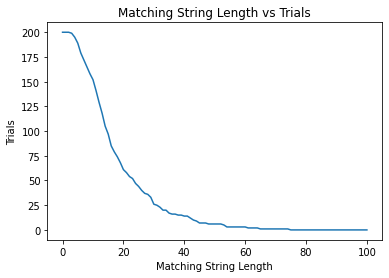

In [23]:
plt.plot(list(matching_counts.keys()), list(matching_counts.values()))
plt.xlabel('Matching String Length')
plt.ylabel('Trials')
plt.title('Matching String Length vs Trials')
plt.show()

In [25]:
matching_counts

{0: 200,
 1: 200,
 2: 200,
 3: 199,
 4: 195,
 5: 189,
 6: 179,
 7: 172,
 8: 165,
 9: 158,
 10: 152,
 11: 141,
 12: 129,
 13: 118,
 14: 105,
 15: 97,
 16: 85,
 17: 79,
 18: 74,
 19: 68,
 20: 61,
 21: 58,
 22: 54,
 23: 52,
 24: 47,
 25: 44,
 26: 40,
 27: 37,
 28: 36,
 29: 33,
 30: 26,
 31: 25,
 32: 23,
 33: 20,
 34: 20,
 35: 17,
 36: 16,
 37: 16,
 38: 15,
 39: 15,
 40: 14,
 41: 14,
 42: 12,
 43: 10,
 44: 9,
 45: 7,
 46: 7,
 47: 7,
 48: 6,
 49: 6,
 50: 6,
 51: 6,
 52: 6,
 53: 5,
 54: 3,
 55: 3,
 56: 3,
 57: 3,
 58: 3,
 59: 3,
 60: 3,
 61: 2,
 62: 2,
 63: 2,
 64: 2,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0}